In [1]:
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
sys.path.append('./../../')

import film as film_mod
import design as design_mod
import spectrum as spec_mod
from optimizer.adam import AdamThicknessOptimizer
from utils.loss import calculate_RMS_f_spec

from analyze_utils.make_design import make_reflection_design

import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy

from analyze_utils.structure import plot_layer_thickness, diff_simple_film
from analyze_utils.result_io import load
from utils.loss import calculate_RMS_f_spec, calculate_RMS
from utils.get_n import get_n_SiO2, get_n_TiO2
from analyze_utils.result_io import save, load

import matplotlib.cm as cmap
import matplotlib.patches as mpatches

from tqdm import trange

In [2]:
def make_rand_new_film_dif_gt(gt):
    layers = 200
    d = np.random.random(layers) * gt / layers * 2 # smaller ot allows for fewer configurations
    film = film_mod.TwoMaterialFilm(1.5, 2.5, 'SiO2', d)
    return film

# Experiment setup (thickness GD)
design = make_reflection_design(make_rand_new_film_dif_gt(0))
target: list[spec_mod.BaseSpectrum] = design.target_specs

rep = 1
gts = np.linspace(200, 5000, 10)

# Run Experiment!
losses_rep = []
best_film_rep = []
for rep_i in trange(rep):
    loss_ls = []
    film_ls = []
    print(rep_i / rep)
    for gt in gts:
        film = make_rand_new_film_dif_gt(gt)
        adam_optimizer = AdamThicknessOptimizer(
            film, 
            target, 
            1000, 
            alpha=1, 
            show=False, 
            record=True, 
            batch_size_wl=200
        )
        films, losses = adam_optimizer()
        loss_ls.append(losses)
        film_ls.append(films)
    losses_rep.append(loss_ls)
    best_film_rep.append(film_ls)

losses_rep = np.array(losses_rep)
best_film_rep = np.array(best_film_rep)


  0%|          | 0/1 [00:00<?, ?it/s]

0.0


/root/miniconda3/envs/tfnn/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/root/miniconda3/envs/tfnn/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 13 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/root/miniconda3/envs/tfnn/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 13 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 1/1 [09:39<00:00, 579.19s/it]


In [3]:
working_file = './back_reflector_result_thickness_optimize'
save(working_file, losses_rep, best_film_rep, design)


/root/miniconda3/envs/tfnn/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/root/miniconda3/envs/tfnn/lib/python3.10/site-packages/matplotlib/axes/_axes.py:4458: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)
/tmp/ipykernel_93841/4145185600.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.plot([0, d.shape[0]], [d_SiO2, d_SiO2], c=cmap.get_cmap('coolwarm')(0), alpha=0.4, ls='--')
/tmp/ipykernel_93841/4145185600.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.plo

film has no spec. use 1000 nm


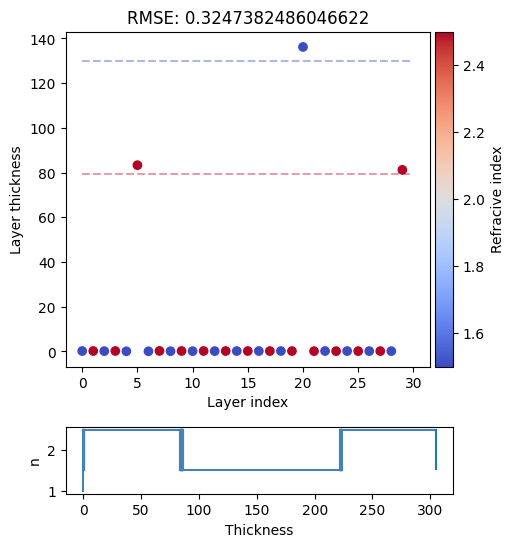

In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_thickness_idx(f, ax, fig):
    d = f.get_d()
    wl = np.array([750.])
    s = ax.scatter(range(d.shape[0]), d, marker='o', cmap='coolwarm', c=f.calculate_n_array(wl)[0, :])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(s, cax=cax, orientation='vertical', label='Refracive index')

    # target: 800 nm DBR
    wl = 800.
    d_SiO2 = wl / 4 / get_n_SiO2(wl)
    d_TiO2 = wl / 4 / get_n_TiO2(wl)
    
    ax.plot([0, d.shape[0]], [d_SiO2, d_SiO2], c=cmap.get_cmap('coolwarm')(0), alpha=0.4, ls='--')
    ax.plot([0, d.shape[0]], [d_TiO2, d_TiO2], c=cmap.get_cmap('coolwarm')(0.99), alpha=0.4, ls='--')
    ax.set_xlabel('Layer index')
    ax.set_ylabel('Layer thickness')
    return fig, ax

i = 0

f: film_mod.TwoMaterialFilm = best_film_rep[0][i][-1]
f.add_spec_param(target[0].INC_ANG, target[0].WLS)
f.remove_negative_thickness_layer()


fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': (5, 1), 'hspace': 0.3})
ax = axes[0]
plot_thickness_idx(f, axes[0], fig=fig)
ax.set_title(f'RMSE: {calculate_RMS_f_spec(f, target)}')

plot_layer_thickness(f, ax=axes[1])
axes[1].set_ylabel('n')
axes[1].set_xlabel('Thickness')

fig.set_size_inches(5, 6)
fig.savefig(f'./../examples_thesis/images/bragg/layer_thickness_{i}.pdf', bbox_inches='tight')

array([[[<film.TwoMaterialFilm object at 0x7fde24638ca0>,
         <film.TwoMaterialFilm object at 0x7fddc1991840>, ...,
         <film.TwoMaterialFilm object at 0x7fddc1602350>, ...,
         <film.TwoMaterialFilm object at 0x7fddbf4d6f50>, ...,
        ...,
         <film.TwoMaterialFilm object at 0x7fddbec205e0>, ...,
         <film.TwoMaterialFilm object at 0x7fddbea01840>, ...,
         <film.TwoMaterialFilm object at 0x7fddbe988cd0>, ...,
         <film.TwoMaterialFilm object at 0x7fddbe767040>]]], dtype=object)